# <h1 align="center">EDA and Model Analysis</h1>

## Data
**I retrieved this data from the following link: https://www.kaggle.com/datasets/pooriamst/best-books-ever-dataset/data. The dataset contains 25 variables and 52478 records corresponding to books on the GoodReads Best Books Ever list. This is a list of The best books ever, as voted on by the general Goodreads community.**

## Problem Definition
I'm curious to understand why readers chose the books they did as "the best books ever". I'm planning on comparing the relative position of a book in the list (bbeVotes) to its rating, total number of awards, and possibly a few other variables.

Type of Problem: Supervised Learning: Regression problem. 

## Objective:
Predict the rank of a book based on its rating and total number of awards.



In [14]:
# Supervised Learning problem to perform EDA and model analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('D:\\repo\\eda-model-analysis-supervised-learning\\dataset\\bestBooks.csv')

print(df.head())

                                        bookId  \
0                     2767052-the-hunger-games   
1  2.Harry_Potter_and_the_Order_of_the_Phoenix   
2                   2657.To_Kill_a_Mockingbird   
3                     1885.Pride_and_Prejudice   
4                               41865.Twilight   

                                       title                 series  \
0                           The Hunger Games    The Hunger Games #1   
1  Harry Potter and the Order of the Phoenix        Harry Potter #5   
2                      To Kill a Mockingbird  To Kill a Mockingbird   
3                        Pride and Prejudice                    NaN   
4                                   Twilight   The Twilight Saga #1   

                                      author  rating  \
0                            Suzanne Collins    4.33   
1  J.K. Rowling, Mary GrandPré (Illustrator)    4.50   
2                                 Harper Lee    4.28   
3  Jane Austen, Anna Quindlen (Introduction)    

In [15]:
# General information about the dataset
print("Shape: ", df.shape)
df.info()
df.describe()
df.describe(include='all')
df.isnull().sum()
df.isnull().sum().sum()
df.isnull().sum().sum()/df.shape[0]

Shape:  (52478, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52478 entries, 0 to 52477
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            52478 non-null  object 
 1   title             52478 non-null  object 
 2   series            23470 non-null  object 
 3   author            52478 non-null  object 
 4   rating            52478 non-null  float64
 5   description       51140 non-null  object 
 6   language          48672 non-null  object 
 7   isbn              52478 non-null  object 
 8   genres            52478 non-null  object 
 9   characters        52478 non-null  object 
 10  bookFormat        51005 non-null  object 
 11  edition           4955 non-null   object 
 12  pages             50131 non-null  object 
 13  publisher         48782 non-null  object 
 14  publishDate       51598 non-null  object 
 15  firstPublishDate  31152 non-null  object 
 16  awards            52

np.float64(2.4198521285109953)

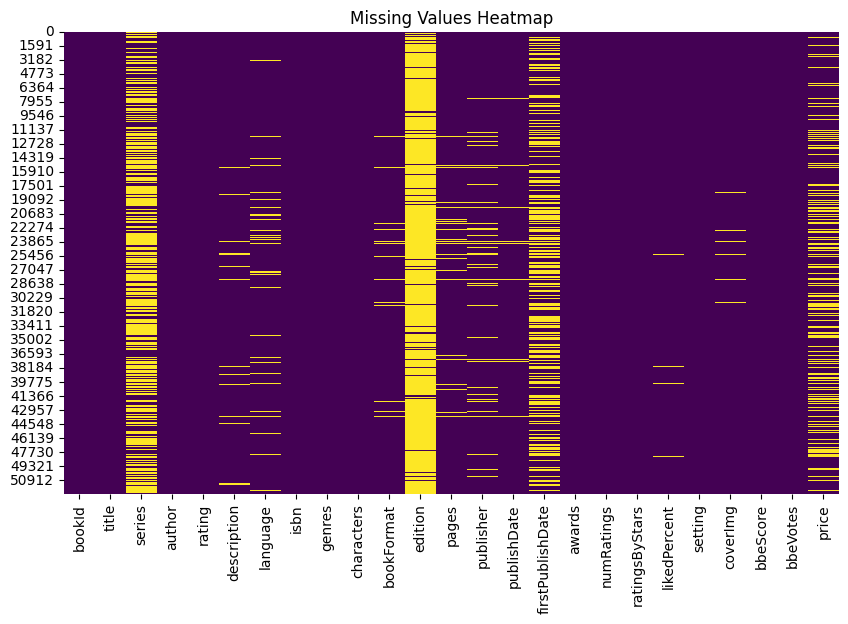

In [16]:
# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

### As you see above, most of the missing values are in features we are not using for the analysis, such as series, edition, and price.

During the Data Cleaning portion of the project, we will be removing all columns that are of no interest to the analysis.

## **CLEANING THE DATA**

In [17]:
# VERY IMPORTANT > Convert awards to numeric - Since awards will be one of my features, I need to convert it to a numeric value (sum of awards).
df['awards_count'] = df['awards'].apply(lambda x: len(eval(x)) if x != '[]' else 0) # isn't Python amazing?

# Feature selection
features = ['rating', 'awards_count', 'numRatings', 'likedPercent', 'bbeVotes']

# drop all other columns
df = df[features]

# Convert necessary columns to numeric
df['numRatings'] = pd.to_numeric(df['numRatings'], errors='coerce')
df['likedPercent'] = pd.to_numeric(df['likedPercent'], errors='coerce')
df['bbeVotes'] = pd.to_numeric(df['bbeVotes'], errors='coerce')

df.columns = df.columns.str.strip() # Remove leading and trailing whitespace from column to ensure 
# consistency and prevent errors when referencing column names in code
print(df.columns)

# Normalize/Standardize features - this is especially important for my linear regression model below
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Handle duplicates
df.drop_duplicates(inplace=True)

# Outlier detection and handling for 'rating' - IQR method
q1 = df['rating'].quantile(0.25)
q3 = df['rating'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df = df[(df['rating'] >= lower_bound) & (df['rating'] <= upper_bound)]

# Drop rows with NaN values in key features - I decided to drop these rows instead of using mean or median imputation because
# the data is not missing in a way that would affect the analysis.
df.dropna(subset=['rating', 'numRatings', 'likedPercent', 'bbeVotes'], inplace=True)

# Check the cleaned data
print(df.head())

Index(['rating', 'awards_count', 'numRatings', 'likedPercent', 'bbeVotes'], dtype='object')
     rating  awards_count  numRatings  likedPercent   bbeVotes
0  0.839243     31.921411   61.176348      0.629058  82.603430
1  1.302278      6.743293   23.952796      0.962913  72.870391
2  0.703056      2.809212   43.130969      0.462131  63.131935
3  0.648581     -0.338053   28.672828      0.295203  55.341170
4 -1.149084     19.332352   47.589572     -2.375634  40.230987


## **General reminder on StandardScaler**
**StandardScaler transforms the data such that it has a mean of 0 and a standard deviation of 1, which is crucial for many machine learning models, particularly those sensitive to feature scales like linear regression.** That's why, if you pay attention to the results above, "awards_count" can be a fraction of even a negative number. 
- For example:
A negative awards count means that book's total sum of awards is under the overall mean. 

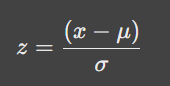

- x is the original value.
- μ is the mean of the feature.
- σ is the standard deviation of the feature.

### Why Standardize?
For linear regression (and many ML models), standardizing can help with:

- Convergence during training (features with vastly different scales can confuse the model).
- Comparing feature importances (coefficients) on a similar scale.

## **Data Cleaning - Conclusion and Discussion**
- Summary: The data cleaning process involved standardizing formats, handling missing values, and ensuring data integrity through deduplication and (TBD)outlier removal.
- Findings: The dataset is fairly clean, with only a few missing values in some columns, which were addressed through imputation or removal.
- Challenges: Balancing data completeness with the need to remove unreliable data was a key challenge.
- Strategy: Focused on retaining as much data as possible while ensuring quality for analysis and modeling.


## **EDA AND VISUALIZATION**
### Features' distribution

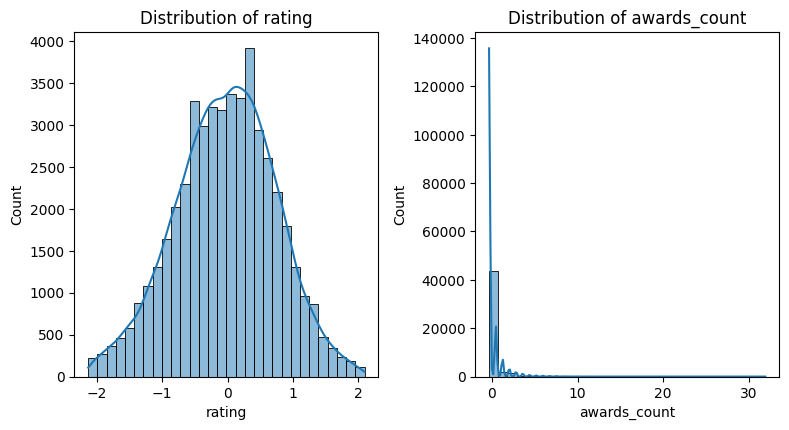

Text(0, 0.5, 'Count')

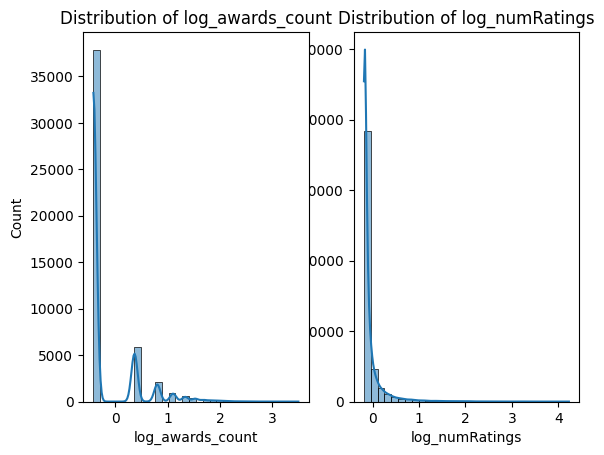

In [18]:
# EDA: Visualize distributions with original values
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features[0:2], 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# FEATURE ENGINEERING
# Apply log transformation to numRatings and awards_count
# Since the vast majority of books have 0 awards, the distribution is heavily skewed to the right, which is why I'm using a log transformation.
# Similar issue with numRatings, since some books have millions of ratings and some have close to 0.
df['log_numRatings'] = np.log1p(df['numRatings'])
df['log_awards_count'] = np.log1p(df['awards_count'])

# EDA: Visualize distribution of log-transformed numRatings - This transformation compresses the scale, 
# making large values more manageable and the graph more readable.
# Log-transformed numRatings
plt.subplot(1, 2, 2)
sns.histplot(df['log_numRatings'], kde=True, bins=30)
plt.title('Distribution of log_numRatings')
plt.xlabel('log_numRatings')
plt.ylabel('Count')

# Log-transformed awards_count
plt.subplot(1, 2, 1)
sns.histplot(df['log_awards_count'], kde=True, bins=30)
plt.title('Distribution of log_awards_count')
plt.xlabel('log_awards_count')
plt.ylabel('Count')


### Comparing different features to bbeVotes

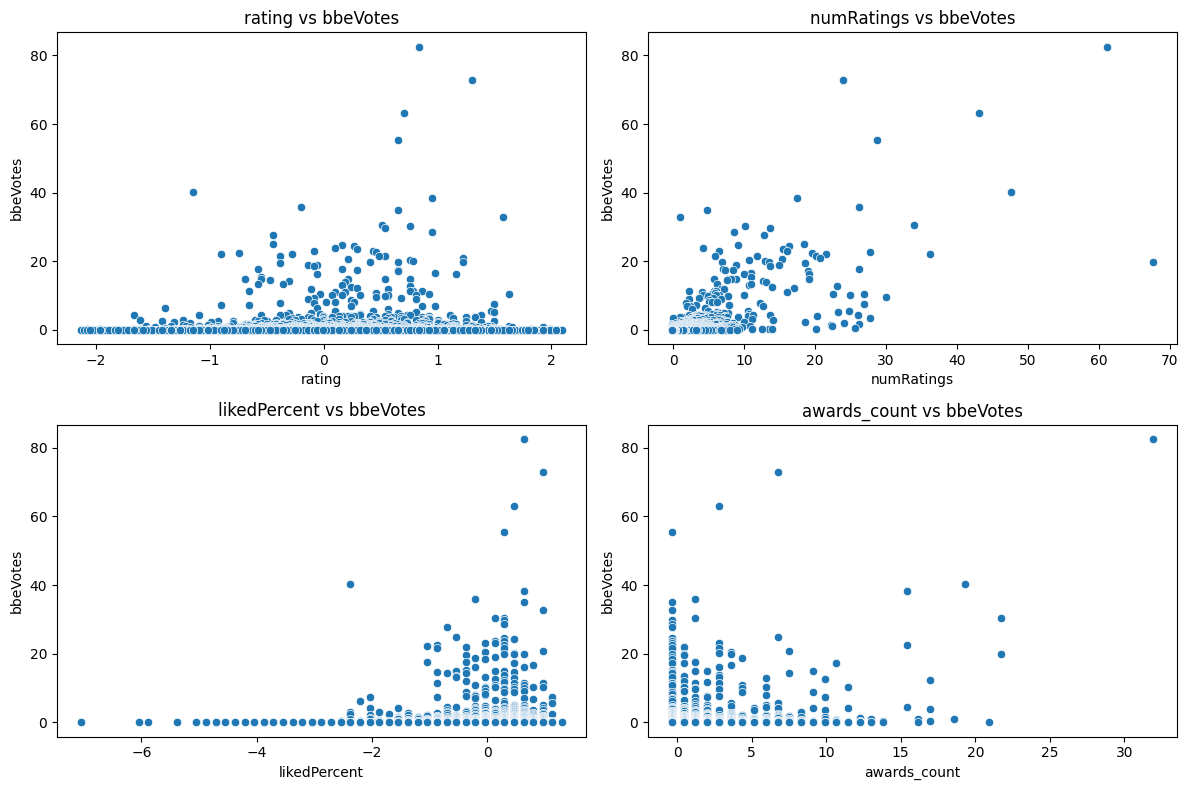

In [19]:
# Features to compare with bbeVotes
comparison_features = ['rating', 'numRatings', 'likedPercent', 'awards_count']

# Visualize relationships with bbeVotes
plt.figure(figsize=(12, 8))
for i, feature in enumerate(comparison_features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=df[feature], y=df['bbeVotes'])
    plt.title(f'{feature} vs bbeVotes')
    plt.xlabel(feature)
    plt.ylabel('bbeVotes')
plt.tight_layout()
plt.show()



## **EDA analysis and conclusions**
Key observations from distributions:

For example: "The rating distribution is close to normal after standardization, suggesting that books' ratings are generally distributed around the mean."
For log_awards_count and log_numRatings: "The log transformation successfully compresses the skewed distributions, making it easier to model the data."
Scatterplots with bbeVotes:

Point out relationships, such as: "The scatterplot shows a strong positive relationship between numRatings and bbeVotes, while other variables such as awards_count and likedPercent show weaker relationships."


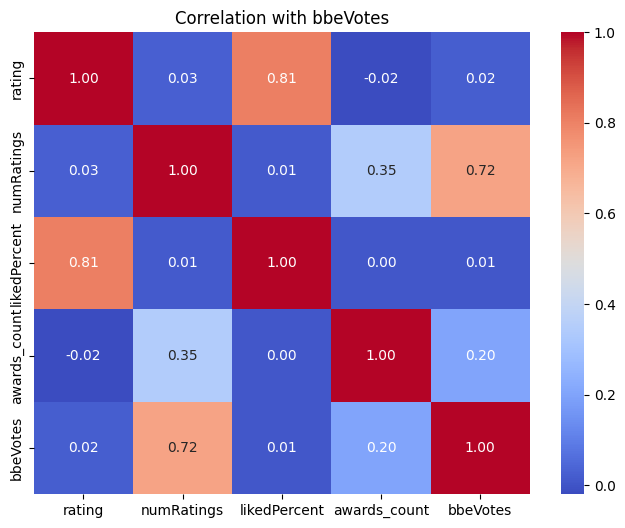

In [20]:
# Correlation analysis
corr_matrix_bbeVotes = df[comparison_features + ['bbeVotes']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_bbeVotes, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation with bbeVotes')
plt.show()

## **Correlation matrix analysis**
Highlight significant correlations, such as:

"numRatings has the highest correlation (0.72) with bbeVotes, which suggests that books with more ratings tend to have more votes on the Best Book Ever list."
"rating has a weaker correlation (0.02) with bbeVotes, indicating that high ratings alone do not translate to more votes."
Discuss why some correlations might be weak or surprising:

For example: "likedPercent has a near-zero correlation with bbeVotes. This could be due to variability in the definition of 'likes' across different books."


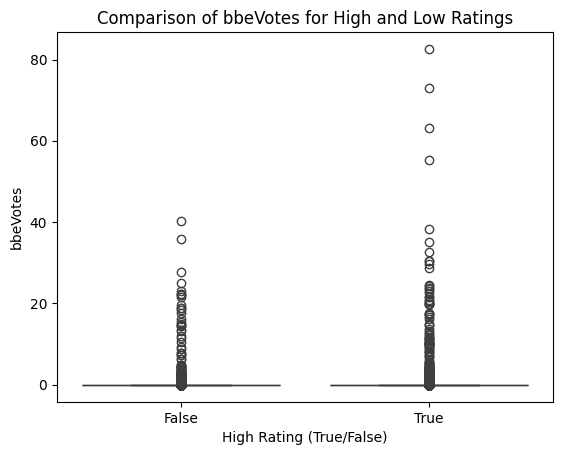

In [21]:
sns.boxplot(x=df['rating'] > df['rating'].mean(), y=df['bbeVotes'])
plt.title("Comparison of bbeVotes for High and Low Ratings")
plt.xlabel("High Rating (True/False)")
plt.ylabel("bbeVotes")
plt.show()

## **Single Model 1 - Linear Regression**

Reasons to start with a linear regression model:
- I will start with a simple linear regression model to provide a baseline. I can use this model to compare the performance of other models.
- Linear models are computationally less intensive compared to non-linear models, making them suitable for large datasets such as this one.
- Linear models are easier to interpret and understand, making it easier to understand the relationship between the features and the target variable.


Problem: Predict the rank of a book based on its rating and total number of awards.
To achieve this, I'll use a linear regression model. The data will be split into training and testing sets, and the model will be trained on the training set and evaluated on the testing set.

To evaluate the model, I'll use the mean squared error (MSE)? and R-squared (R2) metrics?.

In [22]:
X = df[['rating', 'numRatings', 'likedPercent', 'awards_count']] #features
y = df['bbeVotes'] #target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# predictions
y_pred = model.predict(X_test)

# Ensure y_test and y_pred are numeric arrays
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# R²
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# results interpretation
coefficients = model.coef_
feature_importance_lr = pd.DataFrame(coefficients, X.columns, columns=['Coefficient'])
feature_importance_lr = feature_importance_lr.sort_values(by='Coefficient', ascending=False)
print(feature_importance_lr)

RMSE: 0.7715672760773724
R²: 0.43085632125563533
              Coefficient
numRatings       0.746655
rating           0.021607
likedPercent    -0.022223
awards_count    -0.058220


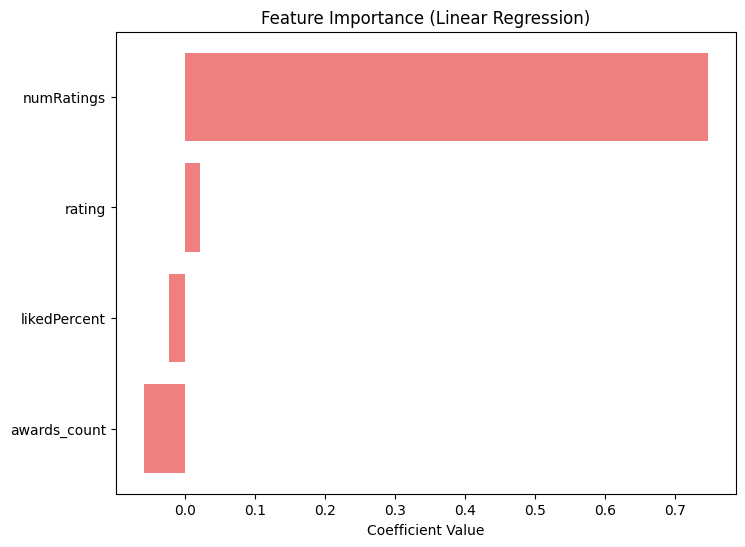

In [23]:
# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_lr.index, feature_importance_lr['Coefficient'], color='lightcoral')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Linear Regression)')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


## **Single Model 2 - Random Forest Regressor**

I will construct multiple decision trees during training and outputs the mean prediction of the individual trees, which will hopefully help me understand the relationship between the features and the target variable.

Reasons to use a Random Forest Regressor:

- Handles Non-Linearity: Can capture complex relationships between features and the target variable.
- Robust to Overfitting: Generally more robust to overfitting than individual decision trees, especially with a large number of trees.
- Feature Importance: Provides insights into feature importance, which can be useful for understanding the model.


In [24]:
# Define features and target
X = df[['rating', 'numRatings', 'likedPercent', 'awards_count']]
y = df['bbeVotes']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Ensure y_test and y_pred_rf are numeric arrays
y_test = np.array(y_test)
y_pred_rf = np.array(y_pred_rf)

# Calculate MSE
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

# R²
r2_rf = r2_score(y_test, y_pred_rf)

print(f'RMSE (Random Forest): {rmse_rf}')
print(f'R² (Random Forest): {r2_rf}')

# Feature importance
feature_importance_rf = pd.DataFrame(rf_model.feature_importances_, X.columns, columns=['Importance'])
feature_importance_rf = feature_importance_rf.sort_values(by="Importance", ascending=False)
print(feature_importance_rf)

RMSE (Random Forest): 0.8714464023596137
R² (Random Forest): 0.273968139278831
              Importance
numRatings      0.724952
awards_count    0.136038
rating          0.086318
likedPercent    0.052692


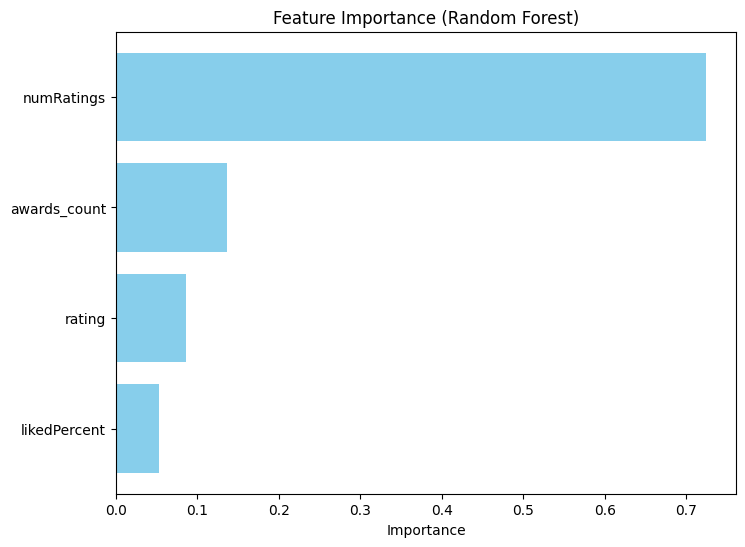

In [25]:
# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_rf.index, feature_importance_rf['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# DISCUSSION AND CONCLUSIONS
## **Linear Regression** > TODO all these numbers have to be fixed
- RMSE (Root Mean Squared Error)
Value: 212.3551
Interpretation: RMSE is a measure of the average magnitude of the errors between the predicted and actual values. In this context, an RMSE of 212.36 suggests that, on average, the model's predictions are off by about 212.36 units of the target variable (bbeVotes). Whether this is a good or bad result depends on the scale of bbeVotes. If bbeVotes values range widely, this might be acceptable; if not, it indicates significant prediction errors.
- R² (R-squared)
Value: 0.5138
Interpretation: R² represents the proportion of variance in the target variable that is explained by the model. An R² of 0.514 means that approximately 51.4% of the variability in bbeVotes is explained by the features in the model. This indicates a moderate fit, suggesting that while the model captures some of the relationships between the features and the target, there is still a substantial amount of unexplained variance.
### Coefficients
- rating: 23.5889
Interpretation: For each unit increase in rating, the model predicts an increase of approximately 23.59 in bbeVotes, assuming all other features remain constant. This positive coefficient suggests that higher-rated books tend to have higher bbeVotes.
- numRatings: 0.0027
Interpretation: For each additional rating, the model predicts an increase of approximately 0.0027 in bbeVotes. This small coefficient indicates that while numRatings has a positive relationship with bbeVotes, its impact is minimal.
- likedPercent: -1.2813
Interpretation: For each percentage point increase in likedPercent, the model predicts a decrease of approximately 1.28 in bbeVotes. This negative coefficient might seem counterintuitive, suggesting that higher likedPercent is associated with lower bbeVotes. This could indicate multicollinearity or that likedPercent is capturing some other underlying effect.
- awards_count: -17.4514
Interpretation: For each additional award, the model predicts a decrease of approximately 17.45 in bbeVotes. This negative relationship might suggest that books with more awards are not necessarily ranked higher in bbeVotes, or it could be due to multicollinearity or other confounding factors.

## **Random Forest Regressor**
